In [34]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

# Add these imports at the beginning of the notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Data

In [3]:
import requests
import tarfile
import os

# Define paths
base_path = os.path.join(os.getcwd(), "Dataset", "Text_Classification")
os.makedirs(base_path, exist_ok=True)  # Create the folder if it doesn't exist
dataset_path = os.path.join(base_path, "aclImdb_v1.tar.gz")
extract_path = os.path.join(base_path, "aclImdb")

# change to True to download
DOWNLOAD_DATASET = True

if (DOWNLOAD_DATASET): 
    # URL of the IMDB dataset
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    # Download the dataset
    print("Downloading IMDB dataset...")
    response = requests.get(url, stream=True)
    with open(dataset_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

    # Extract the dataset
    print("Extracting dataset...")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")

    # Clean up the tar.gz file
    os.remove(dataset_path)
    print("Dataset is ready at:", extract_path)

Download complete.
Extracting dataset...
Extraction complete.
Dataset is ready at: c:\Users\baoqt\OneDrive\Documents\GitHub\GenAIExample\Dataset\Text_Classification\aclImdb


In [36]:
def load_imdb_data(base_path, sample_ratio=0.1): # take 10% of each class for faster example
    texts = []
    labels = []
    
    # Load positive reviews (10%)
    pos_path = os.path.join(base_path, 'train', 'pos')
    pos_files = os.listdir(pos_path)[:int(len(os.listdir(pos_path)) * sample_ratio)]
    for filename in pos_files:
        if filename.endswith('.txt'):
            with open(os.path.join(pos_path, filename), 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(1)
    
    # Load negative reviews (10%)
    neg_path = os.path.join(base_path, 'train', 'neg')
    neg_files = os.listdir(neg_path)[:int(len(os.listdir(neg_path)) * sample_ratio)]
    for filename in neg_files:
        if filename.endswith('.txt'):
            with open(os.path.join(neg_path, filename), 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(0)
    
    return texts, labels

# Load 10% of the data
texts, labels = load_imdb_data(extract_path, sample_ratio=0.1)

# Split into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Print dataset sizes
print(f"Total samples: {len(texts)}")
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Print class distribution
train_pos = sum(train_labels)
train_neg = len(train_labels) - train_pos
val_pos = sum(val_labels)
val_neg = len(val_labels) - val_pos

print("\nClass distribution:")
print(f"Training set: {train_pos} positive, {train_neg} negative")
print(f"Validation set: {val_pos} positive, {val_neg} negative")

Total samples: 2500
Training samples: 2000
Validation samples: 500

Class distribution:
Training set: 1014 positive, 986 negative
Validation set: 236 positive, 264 negative


In [37]:
class SimpleTokenizer:
    def __init__(self, min_freq=2, max_vocab_size=50000):
        self.min_freq = min_freq
        self.max_vocab_size = max_vocab_size
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = {}
        self.vocab_size = 2  # Starting with PAD and UNK tokens
        
    def fit(self, texts):
        # Count word frequencies
        for text in texts:
            for word in text.lower().split():
                self.word_freq[word] = self.word_freq.get(word, 0) + 1
        
        # Build vocabulary based on frequency threshold
        sorted_words = sorted(
            [(word, freq) for word, freq in self.word_freq.items() if freq >= self.min_freq],
            key=lambda x: x[1],
            reverse=True
        )
        
        # Add words to vocabulary (respecting max_vocab_size)
        for word, _ in sorted_words[:self.max_vocab_size - 2]:  # -2 for PAD and UNK
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1
    
    def encode(self, texts, max_length=512, padding=True, truncation=True):
        if isinstance(texts, str):
            texts = [texts]
            
        input_ids = []
        attention_mask = []
        
        for text in texts:
            # Convert text to indices
            tokens = text.lower().split()
            if truncation:
                tokens = tokens[:max_length]
            
            ids = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
            mask = [1] * len(ids)
            
            if padding:
                # Pad sequences to max_length
                padding_length = max_length - len(ids)
                ids = ids + [self.word2idx['<PAD>']] * padding_length
                mask = mask + [0] * padding_length
            
            input_ids.append(ids)
            attention_mask.append(mask)
        
        # Convert to tensors
        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask)
        }
    
    def decode(self, ids):
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()
            
        if isinstance(ids[0], list):
            return [' '.join(self.idx2word.get(id, '<UNK>') for id in sequence) for sequence in ids]
        else:
            return ' '.join(self.idx2word.get(id, '<UNK>') for id in ids)
        
    def tokenize(self, text):
        """Split text into tokens (words)"""
        return text.lower().split()


tokenizer = SimpleTokenizer(min_freq=2, max_vocab_size=50000)
# Fit the tokenizer on training texts
tokenizer.fit(train_texts)

vocab_size = tokenizer.vocab_size  # Get this from your tokenizer


# Model

In [38]:
import torch
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
            
        attention_probs = torch.softmax(attention_scores, dim=-1)
        self.attention_probs = attention_probs  # Store attention probabilities
        output = torch.matmul(attention_probs, V)
        return output
        
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # Linear transformations and reshape
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Reshape and apply final linear transformation
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(output)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention
        attention_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attention_output))
        
        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=512):
        super().__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CustomTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, num_layers=6, d_ff=2048, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.classifier = nn.Linear(d_model, 2)  # 2 classes: positive and negative
        
    def forward(self, input_ids, attention_mask=None):
        # Get embeddings
        x = self.embedding(input_ids)  # [batch_size, seq_len, d_model]
        x = self.positional_encoding(x)
        
        # Store attention weights from last layer
        self.attention_weights = None
        
        # Create attention mask for transformer blocks if provided
        if attention_mask is not None:
            # Expand attention_mask to [batch_size, 1, 1, seq_len]
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            attention_mask = attention_mask.expand(-1, -1, attention_mask.size(-1), -1)
        
        # Pass through transformer blocks
        for i, block in enumerate(self.transformer_blocks):
            x = block(x, attention_mask)
            if i == len(self.transformer_blocks) - 1:
                self.attention_weights = block.attention.attention_probs
        
        # Global average pooling
        x = torch.mean(x, dim=1)  # [batch_size, d_model]
        
        # Classification
        x = self.classifier(x)  # [batch_size, 2]
        return x

# Initialize model
vocab_size = tokenizer.vocab_size  # Get this from your tokenizer
model = CustomTransformerClassifier(vocab_size=vocab_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Create lists to store metrics
training_losses = []
validation_accuracies = []
validation_losses = []

# Train & Evaluate

In [ ]:
# Training loop
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs):
    criterion = nn.CrossEntropyLoss()
    best_val_accuracy = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_dataloader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_dataloader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_losses.append(avg_val_loss)
        
        accuracy = 100 * correct / total
        validation_accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1} Results:")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.2f}%")
        
        # # Save best model
        # if accuracy > best_val_accuracy:
        #     best_val_accuracy = accuracy
        #     torch.save(model.state_dict(), 'best_model.pth')
    
    return model

In [40]:
def predict_with_attention(model, tokenizer, text, device):
    model.eval()
    
    # Tokenize input text - use the encode method instead of calling tokenizer directly
    encoding = tokenizer.encode(text, truncation=True, padding=True, max_length=512)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        # Get model outputs
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1)
        
        # Get attention weights
        attention_weights = model.attention_weights
    
    # Convert prediction to label
    label = "Positive" if prediction.item() == 1 else "Negative"
    confidence = probabilities[0][prediction.item()].item()
    
    return {
        'label': label,
        'confidence': confidence,
        'attention_weights': attention_weights
    }

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_heatmap(text, attention_weights, tokenizer):
    if attention_weights is None:
        print("No attention weights available for visualization")
        return
        
    # Get tokens from input text
    tokens = tokenizer.tokenize(text)
    
    # Limit tokens to what fits in the model (max 512)
    tokens = tokens[:512]
    
    # Average attention weights across heads
    avg_attention = attention_weights.mean(dim=1).squeeze().cpu().numpy()
    
    # Ensure we only plot up to the token length
    max_tokens = min(len(tokens), avg_attention.shape[0])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attention[:max_tokens, :max_tokens],
                xticklabels=tokens[:max_tokens],
                yticklabels=tokens[:max_tokens],
                cmap='viridis')
    plt.title('Attention Weights Heatmap')
    plt.xlabel('Target Tokens')
    plt.ylabel('Source Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_training_history():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(training_losses, label='Training Loss')
    ax1.plot(validation_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(validation_accuracies, label='Validation Accuracy')
    ax2.set_title('Validation Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1/3
----------
Batch 0: Loss = 0.5597
Batch 100: Loss = 0.7166
Epoch 1 Results:
Training Loss: 0.7517
Validation Loss: 0.6967
Validation Accuracy: 47.00%

Epoch 2/3
----------
Batch 0: Loss = 0.6866
Batch 100: Loss = 0.7580
Epoch 2 Results:
Training Loss: 0.6625
Validation Loss: 0.6531
Validation Accuracy: 61.80%

Epoch 3/3
----------
Batch 0: Loss = 0.7156
Batch 100: Loss = 0.5511
Epoch 3 Results:
Training Loss: 0.6336
Validation Loss: 0.6400
Validation Accuracy: 65.40%


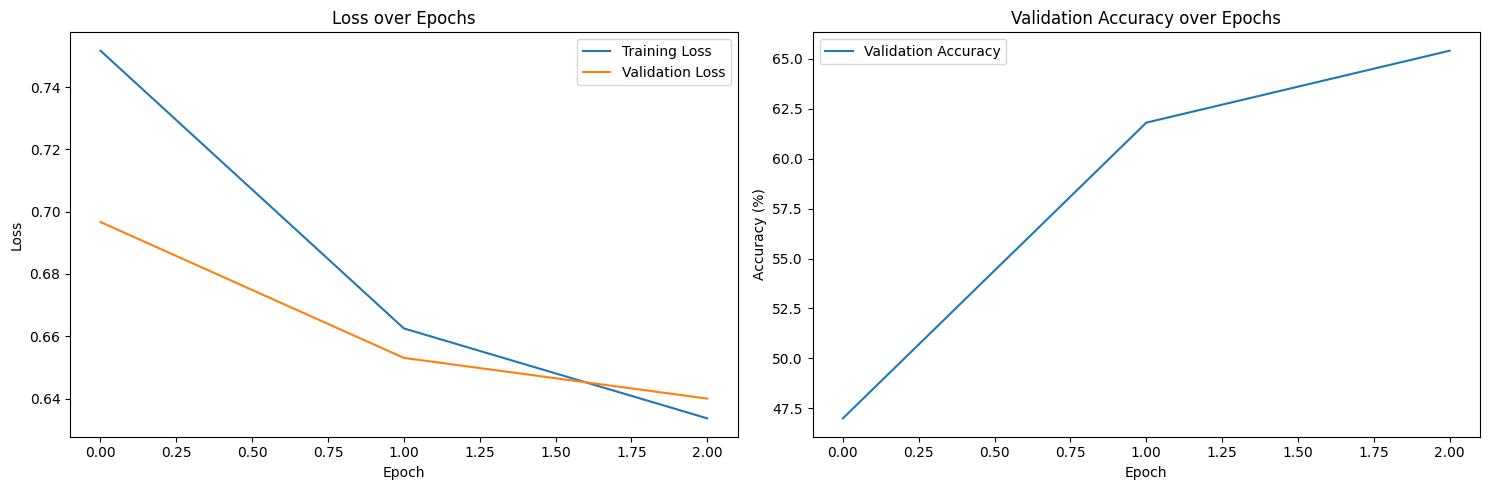

In [42]:
# Initialize empty lists for metrics
training_losses = []
validation_accuracies = []
validation_losses = []

# Tokenize train and validation data
train_input_ids, train_attention_mask = tokenizer.encode(train_texts).values()
train_labels = torch.tensor(train_labels)

# Create DataLoaders
batch_size = 16

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_input_ids, val_attention_mask = tokenizer.encode(val_texts).values()
val_labels = torch.tensor(val_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

# Initialize model and optimizer
model = CustomTransformerClassifier(vocab_size=vocab_size, d_model=512).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Train the model
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
model = train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=3)

# Plot training history after training
plot_training_history()


Negative Example:
Text: This was the worst movie I've ever seen. Terrible acting and boring plot.
Sentiment: Negative
Confidence: 0.99


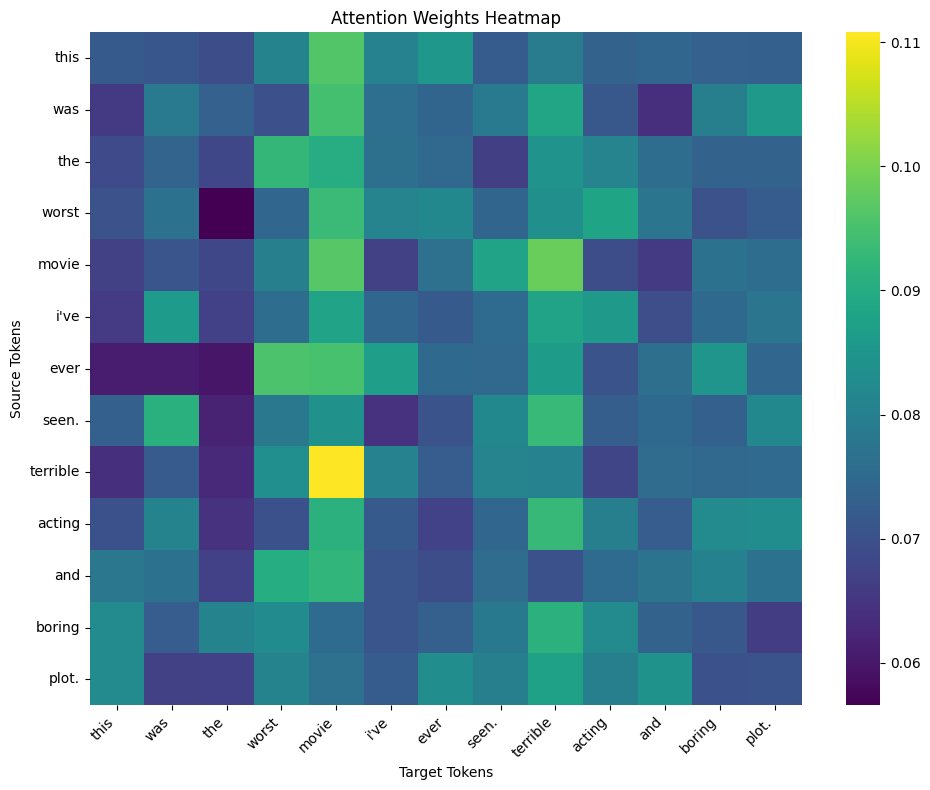

In [43]:
# Add another example with negative sentiment for comparison
test_negative = "This was the worst movie I've ever seen. Terrible acting and boring plot."
result_negative = predict_with_attention(model, tokenizer, test_negative, device)
print(f"\nNegative Example:")
print(f"Text: {test_negative}")
print(f"Sentiment: {result_negative['label']}")
print(f"Confidence: {result_negative['confidence']:.2f}")

# Visualize attention weights
plot_attention_heatmap(test_negative, result_negative['attention_weights'], tokenizer)